# Preparing for Future Pandemics Vaccine Needs

This project aims to help health providers prepare for the vaccination needs for future pandemics. From community clinics to health care providers with hospitals and offices across regions, they will need to know the amount of vaccines needed. The goals are to understand the indicators for receiving pandemic vaccines and build a model that will predict those who will get a pandemic vaccine.

* [Business Understanding](#biz)
* [Data Understanding](#data-und)
* [Data Preperation](#data-prep)
* [Modeling](#mod)
* [Evaluation](#elav)

# Business Question <a class="anchor" id="biz"></a>

How many vaccines healthcare providers need to purchase or request, depending on the national distribution plan, so that all patients who want a vaccine receive one and will not collect a large surplus.

To answer this question we are going to build a model trained on data of who received the h1n1 vaccine, to use to predict individuals who will likely receive a future pandemic vaccination.

While overall accuracy is important, because health care providers would rather have slightly more vaccines than needed, rather than being short and not having vaccines for individuals that requested them, we will focus on achieving a high recall score.

# Data Understanding <a class="anchor" id="data-und"></a>

The data comes from an over 26,000 person phone survey conducted in 2010, a year after the H1N1 outbreak, in which participants were asked about receiving the H1N1 vaccine, the seasonal flu vaccine, opinions about vaccines, behaviors around transmitting illness, and demographic information.
 
First join the training data and the targets and take a look at the dataset.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier

In [2]:
# Set Options

pd.set_option('max_columns', None)
sns.set_palette("colorblind")
sns.set_style("darkgrid")


In [3]:
# Read in csv data files

df = pd.read_csv('data/training_set_features.csv')
df_tars = pd.read_csv('data/training_set_labels.csv')

df_tars.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [4]:
# Join together the files on "respondent_id"

df = df.join(df_tars, on='respondent_id', rsuffix='_tars')

In [5]:
# Sanity check ids match

df.loc[:, ['respondent_id', 'respondent_id_tars']]

,respondent_id,respondent_id_tars
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
26702,26702,26702
26703,26703,26703
26704,26704,26704
26705,26705,26705


In [6]:
# Drop repeated column and sheck shape, then investigate the dataframe

df = df.drop('respondent_id_tars', axis=1)
df.shape

(26707, 38)

In [7]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [9]:
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


In [10]:
df.select_dtypes(include='object').describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


The dataset now has 26707 rows (survey respondents), and 38 columns (variables including id and targets).
 
It has 12 objects and 26 numeric indicators.
Indicators related to behavioral questions are binary,indicators related to opinion questions are a five point scale, numerical and string indicators related to demographics are of varying numbers of response choices, amd respondent ID is a unique identifier. The targets are binary, 0 or 1.
 
'health_insurance', 'employment_industry', and 'employment_occupation' all have over 50% nulls. Other columns contain a small percentage of nulls.

# Data Preperation <a class="anchor" id="data-prep"></a>

What are the numbers for the targets? How many respondents received the vaccines?

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


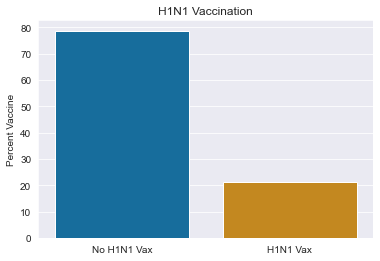

In [11]:
# Look at the percent of respondents who have recieved the H1N1 Vaccine

# Get Proportions
vax_prop = df.h1n1_vaccine.value_counts(normalize=True)
print(vax_prop)


# Chart
fig, ax = plt.subplots()

sns.barplot(x=vax_prop.index, y=vax_prop.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent Vaccine')
ax.set_title("H1N1 Vaccination")

ax.set_xticklabels(['No H1N1 Vax', 'H1N1 Vax'])

plt.savefig('images/vaccine_percents.png', bbox_inches='tight', dpi=300)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64


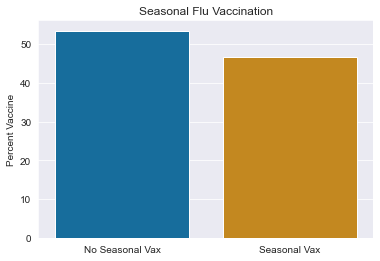

In [12]:
# Look at the proportion of respondents who have recieved seasonal flu Vaccine for comparison

# Get Proportions
vax_prop_seasonal = df.seasonal_vaccine.value_counts(normalize=True)
print(vax_prop_seasonal)


# Chart
fig, ax = plt.subplots()

sns.barplot(x=vax_prop_seasonal.index, y=vax_prop_seasonal.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent Vaccine')
ax.set_title("Seasonal Flu Vaccination")

ax.set_xticklabels(['No Seasonal Vax', 'Seasonal Vax'])

plt.savefig('images/seasonal_vax_percents.png', bbox_inches='tight', dpi=300)

In [113]:
h1n1_rates_house_seas_vax = df.groupby('seasonal_vaccine').mean().h1n1_vaccine
print(h1n1_rates_house_seas_vax, ': ', h1n1_rates_house_seas_vax.max() - \
      h1n1_rates_house_seas_vax.min())

seasonal_vaccine
0    0.068456
1    0.377724
Name: h1n1_vaccine, dtype: float64 :  0.3092684481726502


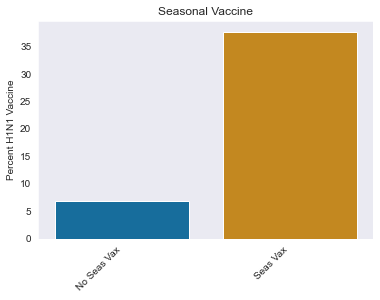

In [115]:
# Visualize percent of no seasonal vaccination and seasonal vaccination with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_house_seas_vax.index, y=h1n1_rates_house_seas_vax.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Seasonal Vaccine')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['No Seas Vax', 'Seas Vax'])
plt.savefig('images/doc_recs_vax_perc.png', bbox_inches='tight', dpi=300)

What percentage of each question response recieved the H1N1 vaccine?

In [13]:
# Get percents of H1N1 vaccinated by response by indicator

# Get percent of vaccinated lkjsdaflk

h1n1_rates_house_adlts = df.groupby('household_adults').mean().h1n1_vaccine
h1n1_rates_house_child = df.groupby('household_children').mean().h1n1_vaccine
h1n1_rates_for_bar_numerical = [h1n1_rates_house_adlts, h1n1_rates_house_child]
h1n1_rates_beh_virmeds = df.groupby('behavioral_antiviral_meds').mean().h1n1_vaccine
h1n1_rates_beh_avoid = df.groupby('behavioral_avoidance').mean().h1n1_vaccine
h1n1_rates_beh_facemask = df.groupby('behavioral_face_mask').mean().h1n1_vaccine
h1n1_rates_beh_washhands = df.groupby('behavioral_wash_hands').mean().h1n1_vaccine
h1n1_rates_beh_gatherings = df.groupby('behavioral_large_gatherings').mean().h1n1_vaccine
h1n1_rates_beh_outside = df.groupby('behavioral_outside_home').mean().h1n1_vaccine
h1n1_rates_beh_touchface = df.groupby('behavioral_touch_face').mean().h1n1_vaccine
h1n1_rates_docrec = df.groupby('doctor_recc_h1n1').mean().h1n1_vaccine
h1n1_rates_chroncond = df.groupby('chronic_med_condition').mean().h1n1_vaccine
h1n1_rates_childund6 = df.groupby('child_under_6_months').mean().h1n1_vaccine
h1n1_rates_healthworker = df.groupby('health_worker').mean().h1n1_vaccine
h1n1_rates_insurance = df.groupby('health_insurance').mean().h1n1_vaccine
h1n1_rates_age = df.groupby('age_group').mean().h1n1_vaccine
h1n1_rates_education = df.groupby('education').mean().h1n1_vaccine
h1n1_rates_race = df.groupby('race').mean().h1n1_vaccine
h1n1_rates_sex = df.groupby('sex').mean().h1n1_vaccine
h1n1_rates_income = df.groupby('income_poverty').mean().h1n1_vaccine
h1n1_rates_marital = df.groupby('marital_status').mean().h1n1_vaccine
h1n1_rates_own = df.groupby('rent_or_own').mean().h1n1_vaccine
h1n1_rates_employment_status = df.groupby('employment_status').mean().h1n1_vaccine
h1n1_rates_geo = df.groupby('hhs_geo_region').mean().h1n1_vaccine.sort_values(ascending=False)
h1n1_rates_census = df.groupby('census_msa').mean().h1n1_vaccine
h1n1_rates_employment_industry = df.groupby('employment_industry').mean().h1n1_vaccine.sort_values(ascending=False)
h1n1_rates_employment_occupation = df.groupby('employment_occupation').mean().h1n1_vaccine.sort_values(ascending=False)
h1n1_rates_houseadlt = df.groupby('household_adults').mean().h1n1_vaccine
h1n1_rates_housechld = df.groupby('household_children').mean().h1n1_vaccine
h1n1_rates_concern = df.groupby('h1n1_concern').mean().h1n1_vaccine
h1n1_rates_knowledge = df.groupby('h1n1_knowledge').mean().h1n1_vaccine
h1n1_rates_op_effective = df.groupby('opinion_h1n1_vacc_effective').mean().h1n1_vaccine
h1n1_rates_op_risk = df.groupby('opinion_h1n1_risk').mean().h1n1_vaccine
h1n1_rates_op_sickfromvac = df.groupby('opinion_h1n1_sick_from_vacc').mean().h1n1_vaccine



h1n1_rates_for_bars = [h1n1_rates_beh_virmeds, h1n1_rates_beh_avoid,
                      h1n1_rates_beh_facemask, h1n1_rates_beh_washhands,
                       h1n1_rates_beh_gatherings, h1n1_rates_beh_outside,
                       h1n1_rates_beh_touchface, h1n1_rates_docrec,
                       h1n1_rates_chroncond, h1n1_rates_childund6,
                       h1n1_rates_healthworker, h1n1_rates_insurance,
                       h1n1_rates_beh_virmeds, h1n1_rates_beh_avoid,
                       h1n1_rates_beh_facemask, h1n1_rates_beh_washhands,
                       h1n1_rates_beh_gatherings, h1n1_rates_beh_outside,
                       h1n1_rates_beh_touchface, h1n1_rates_docrec,
                       h1n1_rates_chroncond, h1n1_rates_childund6,
                       h1n1_rates_healthworker, h1n1_rates_insurance,
                       h1n1_rates_age, h1n1_rates_education,
                       h1n1_rates_race, h1n1_rates_sex,
                       h1n1_rates_income, h1n1_rates_marital,
                       h1n1_rates_own, h1n1_rates_employment_status,
                       h1n1_rates_geo, h1n1_rates_census,
                       h1n1_rates_employment_industry, h1n1_rates_employment_occupation,
                       h1n1_rates_houseadlt, h1n1_rates_housechld, 
                       h1n1_rates_concern, h1n1_rates_knowledge, 
                       h1n1_rates_op_effective, h1n1_rates_op_risk,
                       h1n1_rates_op_sickfromvac
                      ]

In [14]:
# Print percentages by choice and difference between highest and lowest percent by indicator

for i in h1n1_rates_for_bars:
    print(i, ': ', i.max() - i.min(), '\n')

behavioral_antiviral_meds
0.0    0.208171
1.0    0.285165
Name: h1n1_vaccine, dtype: float64 :  0.07699474239654427 

behavioral_avoidance
0.0    0.181131
1.0    0.224880
Name: h1n1_vaccine, dtype: float64 :  0.0437498642769763 

behavioral_face_mask
0.0    0.204532
1.0    0.318305
Name: h1n1_vaccine, dtype: float64 :  0.11377353466222515 

behavioral_wash_hands
0.0    0.146022
1.0    0.226573
Name: h1n1_vaccine, dtype: float64 :  0.08055128590232954 

behavioral_large_gatherings
0.0    0.207169
1.0    0.222374
Name: h1n1_vaccine, dtype: float64 :  0.015204305928348594 

behavioral_outside_home
0.0    0.206302
1.0    0.225142
Name: h1n1_vaccine, dtype: float64 :  0.018839540619657758 

behavioral_touch_face
0.0    0.170319
1.0    0.233043
Name: h1n1_vaccine, dtype: float64 :  0.06272318696732074 

doctor_recc_h1n1
0.0    0.136371
1.0    0.532359
Name: h1n1_vaccine, dtype: float64 :  0.39598870618282755 

chronic_med_condition
0.0    0.188876
1.0    0.275446
Name: h1n1_vaccine, dtype: f

In [15]:
df.employment_industry.value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [16]:
df.employment_occupation.value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, '')])

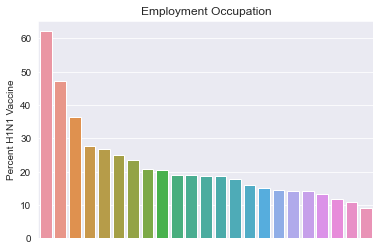

In [17]:
fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_employment_occupation.index, y=h1n1_rates_employment_occupation.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Employment Occupation')

ax.set_xticklabels('')

plt.xticks(rotation=45, ha="right")

Get another look at indicators with the largest difference in percentage between lowest and highest percentage choices with bar plot visualizations.

In [26]:
# Create vizualizations of percentages by choice by indicators

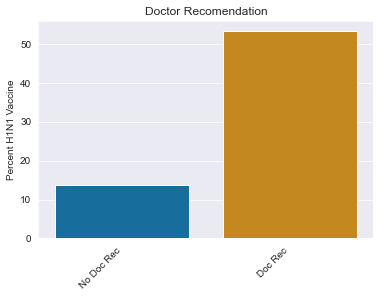

In [27]:
# Visualize proportion of no doc recomended and doc recomended with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_docrec.index, y=h1n1_rates_docrec.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Doctor Recomendation')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['No Doc Rec', 'Doc Rec'])
plt.savefig('images/doc_recs_vax_perc.png', bbox_inches='tight', dpi=300)

 Who did doctors recommend get the vacccine?

In [28]:
# Get percents of doctor response by response by indicator

doctor_recc_rates_age = df.groupby('age_group').mean().doctor_recc_h1n1
print(doctor_recc_rates_age, '\n')
doctor_recc_rates_education = df.groupby('education').mean().doctor_recc_h1n1
print(doctor_recc_rates_education, '\n')
doctor_recc_rates_race = df.groupby('race').mean().doctor_recc_h1n1
print(doctor_recc_rates_race, '\n')
doctor_recc_rates_sex = df.groupby('sex').mean().doctor_recc_h1n1
print(doctor_recc_rates_sex, '\n')
doctor_recc_rates_income = df.groupby('income_poverty').mean().doctor_recc_h1n1
print(doctor_recc_rates_income, '\n')
doctor_recc_rates_marital = df.groupby('marital_status').mean().doctor_recc_h1n1

age_group
18 - 34 Years    0.217536
35 - 44 Years    0.221251
45 - 54 Years    0.203341
55 - 64 Years    0.234421
65+ Years        0.223545
Name: doctor_recc_h1n1, dtype: float64 

education
12 Years            0.202480
< 12 Years          0.200841
College Graduate    0.228896
Some College        0.232847
Name: doctor_recc_h1n1, dtype: float64 

race
Black                0.229102
Hispanic             0.242517
Other or Multiple    0.230717
White                0.216785
Name: doctor_recc_h1n1, dtype: float64 

sex
Female    0.234831
Male      0.198994
Name: doctor_recc_h1n1, dtype: float64 

income_poverty
<= $75,000, Above Poverty    0.216136
> $75,000                    0.235202
Below Poverty                0.235459
Name: doctor_recc_h1n1, dtype: float64 



Nothing jumps out as an imbalance in percent of doctor recommendations, but all percentages are low. What was the overall percentage of those that responded when they received a doctor recommendation?

0.0    0.779688
1.0    0.220312
Name: doctor_recc_h1n1, dtype: float64


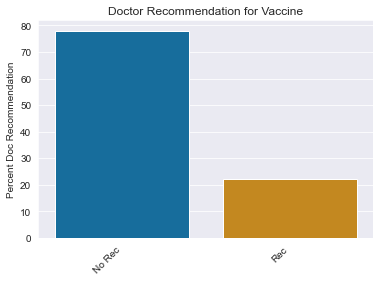

In [29]:
# Look at the percent of respondents who recieved a doctor recommendation to get the vaccine

# Get percents
doc_recc_prop = df.doctor_recc_h1n1.value_counts(normalize=True)
print(doc_recc_prop)


# Chart
fig, ax = plt.subplots()

sns.barplot(x=doc_recc_prop.index, y=doc_recc_prop.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent Doc Recommendation')
ax.set_title("Doctor Recommendation for Vaccine")

plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['No Rec', 'Rec'])

plt.savefig('images/perc_doc_recs.png', bbox_inches='tight', dpi=300)

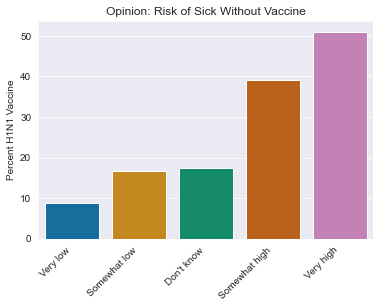

In [30]:
# Visualize proportion of level of respons opinion about risk of getting sick with H1N1 flu without vaccine with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_op_risk.index, y=h1n1_rates_op_risk.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Opinion: Risk of Sick Without Vaccine')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['Very low', 'Somewhat low', "Don't know", 'Somewhat high', 'Very high'])

plt.savefig('images/op_sick_without_vax.png', bbox_inches='tight', dpi=300)

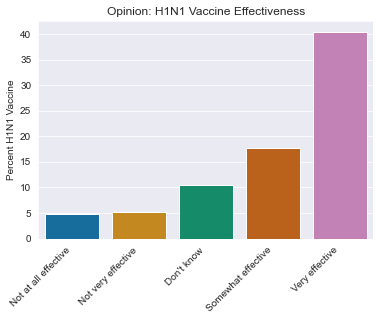

In [31]:
# Visualize proportion of level of respons opinion about seasonal flu vaccine effectiveness with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_op_effective.index, y=h1n1_rates_op_effective.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Opinion: H1N1 Vaccine Effectiveness')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['Not at all effective', 'Not very effective', "Don't know", 'Somewhat effective', 'Very effective'])

plt.savefig('images/op_vax_effective.png', bbox_inches='tight', dpi=300)

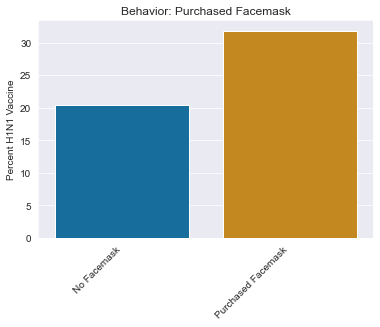

In [32]:
# Visualize proportion of level of respons opinion about seasonal flu vaccine effectiveness with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_beh_facemask.index, y=h1n1_rates_beh_facemask.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Behavior: Purchased Facemask')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['No Facemask', 'Purchased Facemask'])

plt.savefig('images/beh_facemask.png', bbox_inches='tight', dpi=300)

[Text(0, 0, 'Not Frequent'), Text(1, 0, 'Frequent')]

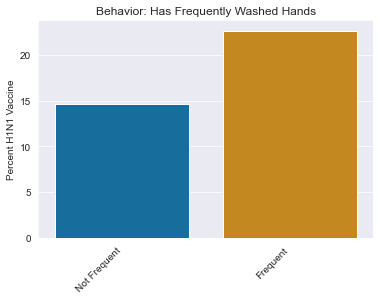

In [33]:
# Visualize proportion of level of respons opinion about seasonal flu vaccine effectiveness with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_beh_washhands.index, y=h1n1_rates_beh_washhands.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Behavior: Has Frequently Washed Hands')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['Not Frequent', 'Frequent'])

[Text(0, 0, 'Not Health Worker'), Text(1, 0, 'Health Worker')]

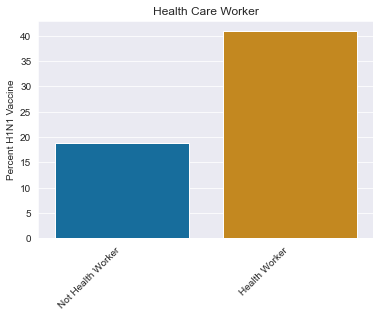

In [34]:
# Visualize proportion of not health care worker and health care worker with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_healthworker.index, y=h1n1_rates_healthworker.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Health Care Worker')
plt.xticks(rotation=45, ha="right")

ax.set_xticklabels(['Not Health Worker', 'Health Worker'])

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Black'),
  Text(1, 0, 'Hispanic'),
  Text(2, 0, 'Other or Multiple'),
  Text(3, 0, 'White')])

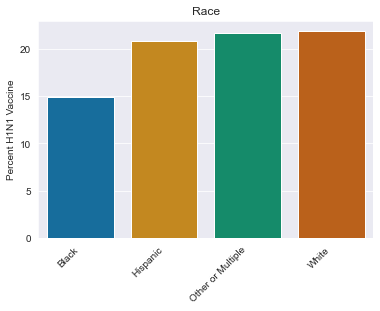

In [35]:
# Visualize proportion of not health care worker and health care worker with H1N1 vaccination

fig, ax = plt.subplots()

sns.barplot(x=h1n1_rates_race.index, y=h1n1_rates_race.values*100)

ax.set_xlabel('')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Race')
plt.xticks(rotation=45, ha="right")

Let's have some fun, as a reminder that human behavior is a difficult thing to predict. Are there respondents that are surprising to find did not receive the H1N1 vaccine? Let's see if anyone who gave the most vaccine positive responses to the questions likeliness to get sick from vaccine, the vaccine is effective, and received a doctor's recommendation and still did not get an H1N1 vaccine.

In [37]:
df_y_no_vax = df[(df['h1n1_vaccine'] == 0) &
                                (df['opinion_h1n1_sick_from_vacc'] == 1) &
                                (df['opinion_h1n1_vacc_effective'] == 5) &
                                (df['doctor_recc_h1n1'] == 1)]

In [38]:
y_no_vax_norm = df_y_no_vax.income_poverty.value_counts(normalize=True)
print(y_no_vax_norm, '\n')
y_no_vax = df_y_no_vax.income_poverty.value_counts()
print(y_no_vax)

<= $75,000, Above Poverty    0.515152
> $75,000                    0.351515
Below Poverty                0.133333
Name: income_poverty, dtype: float64 

<= $75,000, Above Poverty    85
> $75,000                    58
Below Poverty                22
Name: income_poverty, dtype: int64


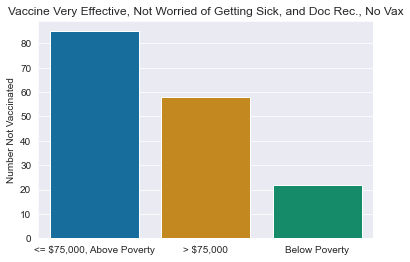

In [39]:
# Chart
fig, ax = plt.subplots()

sns.barplot(x=y_no_vax.index, y=y_no_vax.values)

ax.set_xlabel('')
ax.set_ylabel('Number Not Vaccinated')
ax.set_title("Vaccine Very Effective, Not Worried of Getting Sick, and Doc Rec., No Vax")

ax.set_xticklabels(['<= $75,000, Above Poverty', '> $75,000', 'Below Poverty',])

plt.savefig('images/###.png', bbox_inches='tight', dpi=300)

In [ ]:
# Proportion of those who *&%*&^% who got h1n1 vaccine

likely_vax.groupby('income_poverty').mean().h1n1_vaccine

# Modeling <a class="anchor" id="mod"></a>

Having explored the data some, build first models; a dummy model and first simple model.

In [41]:
X = df.drop(['respondent_id', 'h1n1_vaccine'], axis=1)
y = df.h1n1_vaccine

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [42]:
print(X_train.shape)
print(y_train.shape)

(20030, 36)
(20030,)


Set up transformer pipelines and a cross validation class for modeling.

In [43]:
# Numeric Pipeline, impute missing data and scale

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline, impute missing data and encode categoricals

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Create column transformer to use in model pieplines

CT = ColumnTransformer([
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object)),
], remainder='passthrough')

In [183]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, scoring='recall', cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} recall accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

There is a class imbalance for the target, use SMOTE to create synthetic data to balance the classes.
Use ModelWithCV class to cross validate.

In [185]:
# Create Dummy/Baseline

dummy_smote_model = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('dummy', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Use the class with our dummy pipe

dummy_smoted_model_pipe = ModelWithCV(dummy_smote_model, model_name='dummy_smote', X=X_train, y=y_train)

In [186]:
dummy_smoted_model_pipe.cv_mean

0.0

In [187]:
dummy_smoted_model_pipe.print_cv_summary()

CV Results for `dummy_smote` model:
            0.00000 ± 0.00000 recall accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy_smote` Model'}>

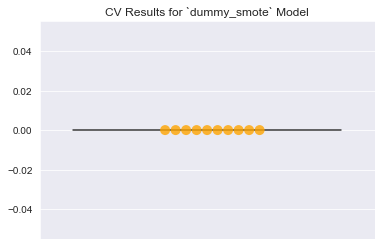

In [188]:
sns.set_style("darkgrid")
fig,ax = plt.subplots()

dummy_smoted_model_pipe.plot_cv(ax=ax)

Our dummy model should have given us a .50 after creating synthetic data, however it did not. This is something to look into fixing. Going with what it produced without synthetic data, it is expected to have a recall score of 0 as it only predicted the most frequent outcome of not getting the vaccine.

The first simple logistic regression model will be sent all data and use SMOTE to balance the classes.

In [191]:
# Use the class with logreg pipe

logreg_fsm = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('logreg_fsm', LogisticRegression(random_state=42, max_iter=1000))
])

In [192]:
fsm_model_pipe = ModelWithCV(logreg_fsm, model_name='fsm', X=X_train, y=y_train)

In [193]:
fsm_model_pipe.print_cv_summary()

CV Results for `fsm` model:
            0.79422 ± 0.02376 recall accuracy
        


<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

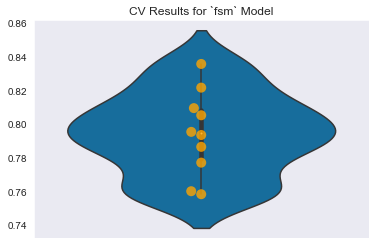

In [194]:
fig,ax = plt.subplots()

fsm_model_pipe.plot_cv(ax=ax)

Make adjustments to the features, drop those with high percentage fo nulls, and sum behavorial group to reduce features and create stronger indicator. To reduce features, combine the behavioral questions into a behaviorial sum category.

beh_sum
0.0    0.120429
1.0    0.162809
2.0    0.207301
3.0    0.227935
4.0    0.227830
5.0    0.230254
6.0    0.284333
7.0    0.333333
Name: h1n1_vaccine, dtype: float64
0.2129042743377214


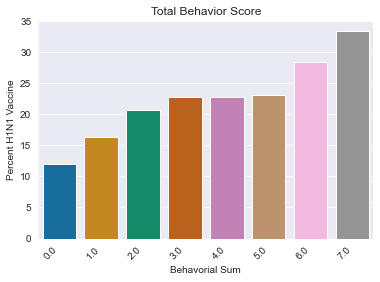

In [195]:
# Create Behavorial Sum

sns.set_style("darkgrid")

#Proportional Behavorial Sum
df['beh_sum'] = df.behavioral_antiviral_meds + df.behavioral_avoidance + \
                df.behavioral_face_mask + df.behavioral_wash_hands + \
                df.behavioral_large_gatherings + df.behavioral_outside_home + \
                df.behavioral_touch_face

beh_sum = df.groupby('beh_sum').mean().h1n1_vaccine
print(beh_sum)
print(beh_sum.max() - beh_sum.min())

fig, ax = plt.subplots()

sns.barplot(x=beh_sum.index, y=beh_sum.values*100)

ax.set_xlabel('Behavorial Sum')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Total Behavior Score')
plt.xticks(rotation=45, ha="right")

plt.savefig('images/beh_totals.png', bbox_inches='tight', dpi=300)

op_sum
3.0     0.026316
4.0     0.032051
5.0     0.049470
6.0     0.070288
7.0     0.081171
8.0     0.115534
9.0     0.132679
10.0    0.165134
11.0    0.282563
12.0    0.357179
13.0    0.463612
14.0    0.617964
15.0    0.742308
Name: h1n1_vaccine, dtype: float64
0.7159919028340082


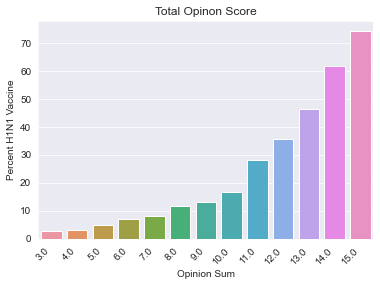

In [196]:
# Ceate Opinion Sum

#Proportional Opinion Sum
df['op_sum'] = df.opinion_h1n1_vacc_effective + df.opinion_h1n1_risk + \
                (6 - df.opinion_h1n1_sick_from_vacc)

op_sum = df.groupby('op_sum').mean().h1n1_vaccine
print(op_sum)
print(op_sum.max() - op_sum.min())

fig, ax = plt.subplots()

sns.barplot(x=op_sum.index, y=op_sum.values*100)

ax.set_xlabel('Opinion Sum')
ax.set_ylabel('Percent H1N1 Vaccine')
ax.set_title('Total Opinon Score')
plt.xticks(rotation=45, ha="right")

plt.savefig('images/op_totals.png', bbox_inches='tight', dpi=300)

In [197]:
# Create dataframe with new features

df_fm = df.copy(['h1n1_concern', 'h1n1_knowledge', 'beh_sum', \
                 'doctor_recc_h1n1', 'chronic_med_condition', 'child_under_6_months', \
                 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', \
                 'opinion_h1n1_sick_from_vacc', 'age_group', 'education', 'race', 'sex', \
                 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', \
                 'hhs_geo_region', 'household_adults', 'household_children', 'seasonal_vaccine', \
                 'h1n1_vaccine'])

In [199]:
df_fm.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,beh_sum,op_sum
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,2.0,8.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,4.0,11.0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1.0,9.0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1,3.0,7.0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,4.0,10.0


In [66]:
# Create new train test split with new dataframe

X = df_fm.drop(['respondent_id', 'h1n1_vaccine'], axis=1)
y = df_fm.h1n1_vaccine

X_clean_train, X_clean_test, y_clean_train, y_clean_test = train_test_split(X,y,random_state=42)

The next model will be the same model type and parmeters with the adjusted data.

In [200]:
fsm_clean_model_pipe = ModelWithCV(logreg_fsm, model_name='fsm_clean', X=X_clean_train, y=y_clean_train)

In [201]:
fsm_clean_model_pipe.cv_mean

0.7949229494614747

In [ ]:
fsm_clean_model_pipe.

<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

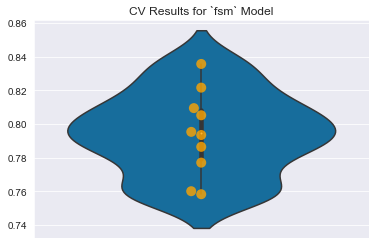

In [202]:
fig,ax = plt.subplots()

fsm_model_pipe.plot_cv(ax=ax)

This simple model with the adjusted features produced almost exactly the same results, but with less features will help run future models faster.

Use grid search to find the best parameters for a logistic regression model.

In [204]:
# Logistic Regression

lr = LogisticRegression(random_state=42, max_iter=1000)

lr_model_pipe = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('lr', lr)
])

lr_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'lr__penalty' : ['l1', 'l2', 'elasticnet'],
    'lr__C' : [100, 10, 1.0, 0.1, 0.01],
    'lr__solver' : ['lbfgs', 'liblinear', 'saga'],
}

In [ ]:
gs_lr = GridSearchCV(estimator=lr_model_pipe, param_grid=lr_params, scoring='recall', cv=10, verbose=2)

gs_lr.fit(X_clean_train, y_clean_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_so

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   3.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   3.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   4.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   3.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   4.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__pen

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   6.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   7.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   7.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   8.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   8.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_t

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=100, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear, total=   4.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear, total=   4.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear, total=   7.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, lr__solver=liblinear, total=   5.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l1, l

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga, total=   7.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga, total=   8.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga, total=   7.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga, total=  10.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga, total=   8.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   4.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   3.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=10, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, total=   5.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, total=   4.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, total=   4.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, total=   4.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__pen

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga, total=  15.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga, total=  15.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga, total=  16.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga, total=  16.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga, total=  14.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_t

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=1.0, lr__penalty=elasticnet, lr__solver=saga, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, total=   3.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, total=   3.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, total=   4.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, total=   3.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__pen

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga, total=   6.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga, total=   6.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga, total=   6.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga, total=   6.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga, total=   6.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_t

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.2s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.3s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.1, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   3.5s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.0

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga, total=   3.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga, total=   3.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga, total=   3.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga, total=   3.6s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga, total=   3.4s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=l2, lr__solver=saga 
[CV] 

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
Value

[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=liblinear, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  ct__num_trans__num_impute__strategy=mean, lr__C=0.01, lr__penalty=elasticnet, lr__solver=saga, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Va

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=lbfgs, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   3.1s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   3.7s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   5.2s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l1, lr__solver=liblinear, total=   4.9s
[CV] ct__num_trans__num_impute__strategy=median

[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=liblinear, total=   3.6s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   6.4s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   7.0s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   6.9s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga 
[CV]  ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__solver=saga, total=   8.7s
[CV] ct__num_trans__num_impute__strategy=median, lr__C=100, lr__penalty=l2, lr__sol

In [146]:
gs_lr.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'lr__C': 0.01,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [147]:
gs_lr.best_score_

0.8076128141397405

Use grid search to find the best parameters for a random forest classifier model.

In [150]:
# Random Forest Classsifier

rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('rfc', rfc)])

rfc_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'rfc__criterion' : ['gini', 'entropy', 'log_loss'],
    'rfc__max_depth' : [9, 11, 13, 15],
    'rfc__min_samples_leaf' : [1, 5, 15,]
}

In [151]:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=rfc_params, scoring='recall', cv=10, verbose=2)

gs_rfc.fit(X_clean_train, y_clean_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.5s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=me

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   6.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=me

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   6.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=me

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans_

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   6.0s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   6.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=15 
[CV]  ct__num

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   6.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15 
[CV]  ct__nu

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   3.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.3s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.4s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   5.3s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=11, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   5.5s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   5.5s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   5.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=13, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_imp

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_imp

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=5 
[CV]

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   6.0s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   6.0s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   6.0s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=13, rfc__min_samples_leaf=5 
[CV]

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=15, rfc__min_samples_leaf=15 
[

C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.6s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=13, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=1, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=5, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15 


C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jtdja\anaconda3\envs\learn-env\lib\site-packa

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=log_loss, rfc__max_depth=15, rfc__min_samples_leaf=15, total=   2.7s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A1471A790>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('ca

In [152]:
gs_rfc.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'rfc__criterion': 'entropy',
 'rfc__max_depth': 11,
 'rfc__min_samples_leaf': 15}

In [153]:
gs_rfc.best_score_

0.62602209334438

Because the best parameters had a parameter, min_sample_leaf, at the far end of our options, run another model with the best  parameters but increasing the options for min_sample_leaf. 

In [174]:
rfc_params_adj_leafs = {
    'ct__num_trans__num_impute__strategy' : ['mean'],
    'rfc__criterion' : [ 'entropy'],
    'rfc__max_depth' : [11],
    'rfc__min_samples_leaf' : [15, 17, 19, 21, 23]
}

In [175]:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=rfc_params_adj_leafs, scoring='recall', cv=10, verbose=2)

gs_rfc.fit(X_clean_train, y_clean_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   6.1s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   5.9s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=15 
[CV]  ct__nu

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21, total=   5.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21, total=   5.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=11, rfc__min_samples_leaf=21 
[CV]  ct__nu

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.8min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A1471A790>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('ca

In [179]:
gs_rfc.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'rfc__criterion': 'entropy',
 'rfc__max_depth': 11,
 'rfc__min_samples_leaf': 21}

In [176]:
gs_rfc.best_score_

0.6295476387738195

Use grid search to find the best parameters for a k-nearest neighbors classifier model.

In [180]:
# K-Nearest Neighbors Classifier

knn = KNeighborsClassifier()

knn_model_pipe = ImPipeline([
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('knn', knn)])

knn_params = {
    'ct__num_trans__num_impute__strategy' : ['mean', 'median'],
    'knn__n_neighbors' : [1, 3, 5, 7, 9, 11],
    'knn__weights' : ['uniform', 'distance'],
    'knn__leaf_size' : [5, 10, 20, 30, 40],
    'knn__metric' : ['minkowski', 'cityblock']
}

In [181]:
gs_knn = GridSearchCV(estimator=knn_model_pipe, param_grid=knn_params, scoring='recall', cv=10, verbose=2)

gs_knn.fit(X_clean_train, y_clean_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  22.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  21.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  21.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  22.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  22.2s
[CV] ct__num_trans__num_impute

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  23.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  23.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  23.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  23.6s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  24.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  25.0s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  25.0s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  24.9s
[CV] ct__num_trans__num_impute

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  24.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  25.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  25.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  25.3s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  19.4s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  19.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  19.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  19.7s
[CV] ct__num_trans__num_impute

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  20.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  20.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  21.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  20.9s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  21.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  21.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  21.2s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  21.2s
[CV] ct__num_trans__num_impute

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  21.2s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  21.4s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  21.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=5, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  21.4s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  17.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  17.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  17.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  17.6s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  18.4s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  18.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  18.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  18.4s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  19.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  19.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  19.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  19.1s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  19.4s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  19.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  19.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  19.3s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  17.2s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  17.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  17.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  17.4s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  17.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  17.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  17.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  17.6s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  17.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  18.0s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  17.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  17.7s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  17.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  17.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  17.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=10, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  17.9s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  14.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  15.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  15.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  15.0s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  15.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  15.5s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  16.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  16.2s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  16.2s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  16.0s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  16.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  16.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  16.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  16.1s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  15.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  15.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  15.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  15.5s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  15.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=3, knn__weights=distance, total=  15.9s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  16.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=7, knn__weights=uniform, total=  15.6s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  15.8s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  16.0s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  15.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=20, knn__metric=cityblock, knn__n_neighbors=9, knn__weights=distance, total=  15.6s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  13.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  13.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  13.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=1, knn__weights=uniform, total=  13.6s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  14.0s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  14.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  14.1s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance, total=  13.9s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  14.4s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  14.4s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  14.5s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform, total=  14.4s
[CV] ct__num_trans__num

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  14.7s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  15.9s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  15.3s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance, total=  15.6s
[CV] ct__num_tra

[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  15.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  16.6s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  16.2s
[CV] ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform 
[CV]  ct__num_trans__num_impute__strategy=mean, knn__leaf_size=30, knn__metric=cityblock, knn__n_neighbors=1, knn__weights=uniform, total=  15.5s
[CV] ct__num_trans__num

KeyboardInterrupt: 

In [ ]:
gs_knn.bes

# Evlauation <a class="anchor" id="eval"></a>

The logistic regression model with a numerical impute strategy of 'mean, C: .01, penalty: l1, and solver: liblinear, was our best performing model on trained data and cross validation. Now compare the test data.

In [ ]:
sns.set_style("dark")
gs_lr.best_estimator_.fit(X_train, y_train)
y_pred = gs_lr.best_estimator_.predict(X_test)
plot_confusion_matrix(estimator=gs_lr.best_estimator_, X=X_test, y_true=y_test)

plt.savefig('images/cm_log_reg.png', bbox_inches='tight', dpi=300)

In [ ]:
recall_score(y_clean_test, y_pred)